Train Normal: 1349
Train Pneumonia: 3883
Test Normal: 234
Test Pneumonia: 390
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6973 - loss: 0.5918 - val_accuracy: 0.9074 - val_loss: 0.2929
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7347 - loss: 0.4922 - val_accuracy: 0.8720 - val_loss: 0.2758
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7662 - loss: 0.4685 - val_accuracy: 0.9647 - val_loss: 0.1523
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.7552 - loss: 0.4751 - val_accuracy: 0.8586 - val_loss: 0.2590
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8005 - loss: 0.4273 - val_accuracy: 0.9265 - val_loss: 0.1999
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8013 - loss: 0.4221 - val_accuracy: 0.9312 - val_loss: 0.1866
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8224 - loss: 0.3900 - val_accuracy: 0.9093 - val_loss: 0.2199
Epoch 8/20
131/131 

Model saved as pneumonia_model.h5

Evaluating on test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.5756 - loss: 1.8658
Test Accuracy: 75.00%
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.40      0.54       234
   Pneumonia       0.73      0.96      0.83       390

    accuracy                           0.75       624
   macro avg       0.79      0.68      0.69       624
weighted avg       0.78      0.75      0.72       624



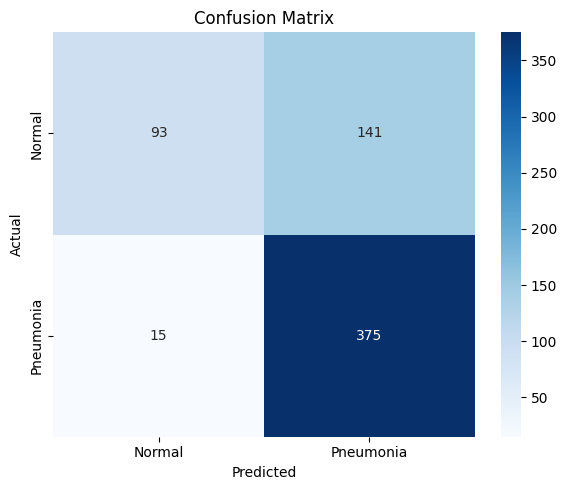

In [2]:
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Load Dataset Using glob
# ===============================
train_normal = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\train\NORMAL\*.*")
train_pneumonia = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\train\PNEUMONIA\*.*")
test_normal = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\test\NORMAL\*.*")
test_pneumonia = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\test\PNEUMONIA\*.*")

print("Train Normal:", len(train_normal))
print("Train Pneumonia:", len(train_pneumonia))
print("Test Normal:", len(test_normal))
print("Test Pneumonia:", len(test_pneumonia))

train_images = []
train_labels = []

for path in train_normal:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    train_images.append(img_to_array(img))
    train_labels.append(0)

for path in train_pneumonia:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    train_images.append(img_to_array(img))
    train_labels.append(1)

test_images = []
test_labels = []

for path in test_normal:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    test_images.append(img_to_array(img))
    test_labels.append(0)

for path in test_pneumonia:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    test_images.append(img_to_array(img))
    test_labels.append(1)

# Normalize and convert to numpy arrays
train_x = np.array(train_images, dtype='float32') / 255.0
train_y = np.array(train_labels)
test_x = np.array(test_images, dtype='float32') / 255.0
test_y = np.array(test_labels)

# ===============================
# 2. CNN + LSTM Hybrid Model
# ===============================
inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(2, 2)(x)
x = Reshape((-1, 32))(x)
x = LSTM(64)(x)
x = Dense(32, activation='elu', kernel_initializer='he_uniform')(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# ===============================
# 3. Compile and Train
# ===============================
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs=20, validation_split=0.2)

model.save('pneumonia_model.h5')
print("Model saved as pneumonia_model.h5")

# ===============================
# 4. Evaluation
# ===============================
print("\nEvaluating on test data...")
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
pred_y = np.argmax(model.predict(test_x), axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(test_y, pred_y, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix
cm = confusion_matrix(test_y, pred_y)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
